#### CPT1B 
#### NRF1 

(Segmentation on DAPI & NeuN)

- Nothing for CPT1B
- NRF1 down in KO vs E3 (but only 2 E3), and up by choline

In [1]:
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
import sys
sys.path.append(path_to_quant)

# import packages
import numpy as np
from aicsimageio import AICSImage
import torch as ch
from tqdm import tqdm
from os import path
import argparse
from distutils.util import strtobool
import os
import ast
import pandas as pd
from cellpose import models
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm


from confocalQuant.segmentation import load_3D, int_to_float, run_med_filter, bgrnd_subtract, get_anisotropy, do_inference, sigmoid, gamma_correct_image, get_czi_files, extract_channels, impose_segmentation, float_to_int, hide_masks, impose_segmentation_all
from confocalQuant.stats import get_expectations, compute_nested_anova
from confocalQuant.qc import return_channel_moments_per_im, get_day_and_time, get_metadata
from confocalQuant.plotting import plot_hist, plot_treatments, plot_lines, plot_scatter
from confocalQuant.image import save_mean_proj, add_inset, plot_axis, get_rep_im, add_scale_bar, get_mean_projections
from confocalQuant.data_handling import get_id_data, return_results, return_non_unique_indices, print_metadata, compute_avs, extract_sbatch_parameters
from confocalQuant.widgets import toggle_filters

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
# get files
parent = '../data/iNbatch01312024_PLIN2_Lipidspot////'
files = get_czi_files(parent)

In [3]:
# get meta
meta = pd.read_csv(parent + 'temp.csv')
meta.columns = ['well', 'Treatment']
meta['line'] = np.array([str(x).split(' ')[0] for x in meta['Treatment']])
meta['treatment'] = treat = np.array([str(x).split(' ')[1] if len(str(x).split(' '))>1 else np.nan for x in meta['Treatment']])

# get line / treatment info
dictionary = dict(zip(meta['well'], meta['line']))
dictionary2 = dict(zip(meta['well'], meta['treatment']))
lines = np.array([dictionary[x.split('.')[0]] for x in files])
treat = np.array([dictionary2[x.split('.')[0]] for x in files])

In [ ]:
# Ch1-NRF2 > Ch2-CTP1B > Ch3-NeuN/GFP > Ch4-DAPI

In [4]:
# load data
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results('../outs/iNbatch01312024_PLIN2_Lipidspot_out/run_iNbatch01312024_PLIN2_Lipidspot.sbatch', '.')

In [17]:
lines

array(['Y622', 'Y622', 'Y622', 'G2', 'Y622', 'Y622', 'G2', 'G2', 'G2',
       'G2', 'G2', 'Y622', 'Y622', 'Y622', 'E3', 'E3', 'E3', 'E3', 'G2',
       'G2', 'Y622', 'Y622', 'G2', 'G2', 'G2', 'G2', 'G2', 'Y622', 'Y622',
       'Y622', 'G2', 'G2', 'G2', 'Y622', 'Y622', 'Y622', 'Y622', 'E3',
       'G2', 'G2'], dtype='<U4')

In [23]:
treat

array(['vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle',
       'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle',
       'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle',
       'vehicle', 'vehicle', 'vehicle', 'CDP-choline', 'CDP-choline',
       'CDP-choline', 'CDP-choline', 'CDP-choline', 'CDP-choline',
       'vehicle', 'vehicle', 'CDP-choline', 'CDP-choline', 'CDP-choline',
       'CDP-choline', 'CDP-choline', 'CDP-choline', 'CDP-choline',
       'CDP-choline', 'CDP-choline', 'CDP-choline', 'CDP-choline',
       'CDP-choline', 'vehicle', 'vehicle', 'vehicle', 'vehicle',
       'CDP-choline', 'CDP-choline', 'CDP-choline', 'CDP-choline',
       'rosiglitazone', 'rosiglitazone', 'rosiglitazone', 'rosiglitazone',
       'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle', 'vehicle',
       'rosiglitazone', 'rosiglitazone', 'rosiglitazone', 'rosiglitazone',
       'rosiglitazone', 'rosiglitazone', 'rosiglitazone', 'rosiglitazone',
     

In [5]:
# toggle segmentation
val = 1
out_seg = []
for i in tqdm(range(len(files[:3]))): #
    out_seg.append(impose_segmentation_all(i, zi_per_job, Nzi_per_job, all_mat, all_masks, val))
    
toggle_filters(files, parent, [3,2,0,1], out_seg) #index1], files[index2]

100%|██████████| 3/3 [00:08<00:00,  2.85s/it]


In [ ]:
Ch1-Lipidspot > Ch2-PLIN2 > Ch3-NeuN/GFP > Ch4-DAPI


In [5]:
channels = [0,1,2,3]
channel_names = ['DAPI', 'NeuN', 'Lipidspot', 'PLIN']
resE = []
resV = []
resN = []

for ID in tqdm(range(len(files))):
    start = ID*zi_per_job
    end = start + Nzi_per_job[ID][0]
    
    probs_sele = probs[start:end].ravel()
    masks_sele = all_masks[start:end].ravel()
    out_float_sele = all_mat[start:end]
    
    M_unique = np.unique(masks_sele)
    NM = len(M_unique)
    
    outputs_E = np.empty((NM, len(channels)))
    outputs_V = np.empty((NM, len(channels)))
    outputs_N = np.empty((NM, len(channels)))

    E = np.empty(NM)
    V = np.empty(NM)
    N = np.empty(NM)
    
    for C in channels:
        vals_sele = out_float_sele[:,:,:,C].ravel()
        get_expectations(NM, masks_sele, probs_sele, vals_sele, E, V, N)
        outputs_E[:,C] = E
        outputs_V[:,C] = V
        outputs_N[:,C] = N

    df_E = pd.DataFrame(outputs_E[1:])
    df_E.columns = ['channel_' + str(i) for i in channel_names]
    df_E['ID'] = ID
    df_E['file'] = files[ID]
    df_E['line'] = lines[ID]
    df_E['treatment'] = treat[ID]

    df_V = pd.DataFrame(outputs_V[1:])
    df_V.columns = ['channel_' + str(i) for i in channel_names]
    df_V['ID'] = ID
    df_V['file'] = files[ID]
    df_V['line'] = lines[ID]
    df_V['treatment'] = treat[ID]
    
    df_N = pd.DataFrame(outputs_N[1:])
    
    resE.append(df_E)
    resV.append(df_V)
    resN.append(df_N)
    
# concatenate the results

resE = pd.concat(resE)
resE['well'] = [x.split('-')[0] for x in resE['file']]
resE.index = range(resE.shape[0])

resV = pd.concat(resV)
resV['well'] = [x.split('-')[0] for x in resV['file']]
resV.index = range(resV.shape[0])

resN = pd.concat(resN)
resN.index = range(resN.shape[0])
resE['size'] = resN[0]

resE.to_csv('../outs/iNbatch01312024_PLIN2_Lipidspot_out//resE_DAPI_and_NeuN.csv')

  0%|          | 0/75 [00:00<?, ?it/s]/home/gridsan/djuna/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 75/75 [09:26<00:00,  7.56s/it]


In [5]:
# load quantifications
resE = pd.read_csv('../outs/iNbatch01312024_PLIN2_Lipidspot_out/resE_DAPI_and_NeuN.csv')

In [5]:
resE.head()

,Unnamed: 0,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN,ID,file,line,treatment,well,size
0,0,0.027406,0.045650,0.006059,0.009919,0,B03-1.czi,Y622,vehicle,B03,17111.0
1,1,0.037598,0.028137,0.010067,0.017318,0,B03-1.czi,Y622,vehicle,B03,15098.0
2,2,0.049407,0.040041,0.013233,0.018810,0,B03-1.czi,Y622,vehicle,B03,14038.0
3,3,0.049418,0.031024,0.011104,0.018395,0,B03-1.czi,Y622,vehicle,B03,13911.0
4,4,0.055015,0.026128,0.010955,0.020519,0,B03-1.czi,Y622,vehicle,B03,13223.0


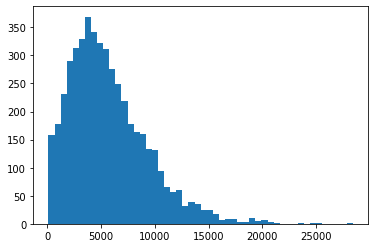

In [7]:
plt.hist((resE['size']), 50)
None

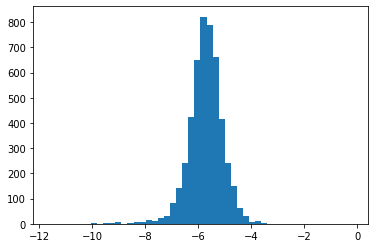

In [9]:
plt.hist(np.log2((resE['channel_PLIN'])+0.0001), 50)
None

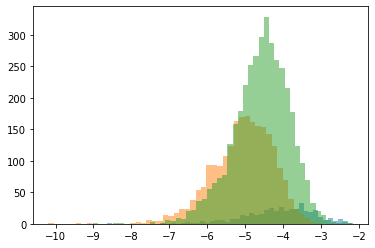

In [11]:
for i in np.unique(resE['line']):
    
    plt.hist(np.log2((resE[resE['line']==i]['channel_NRF2'])+0.0001), 50, alpha=.5)
    None


In [10]:
resE.head()

,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN,ID,file,line,treatment,well,size
0,0.027406,0.045650,0.006059,0.009919,0,B03-1.czi,Y622,vehicle,B03,17111.0
1,0.037598,0.028137,0.010067,0.017318,0,B03-1.czi,Y622,vehicle,B03,15098.0
2,0.049407,0.040041,0.013233,0.018810,0,B03-1.czi,Y622,vehicle,B03,14038.0
3,0.049418,0.031024,0.011104,0.018395,0,B03-1.czi,Y622,vehicle,B03,13911.0
4,0.055015,0.026128,0.010955,0.020519,0,B03-1.czi,Y622,vehicle,B03,13223.0


In [6]:
resE['logL'] = np.log2(resE['channel_Lipidspot']+0.0001)
resE['logP'] = np.log2(resE['channel_PLIN']+0.0001)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


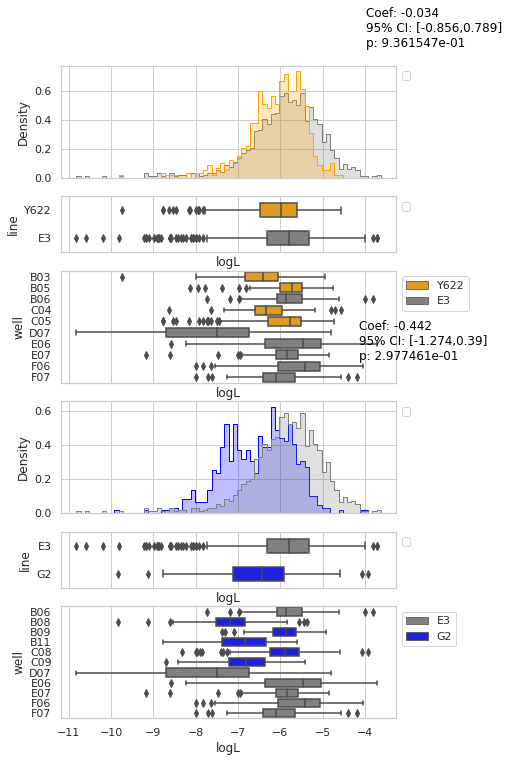

In [12]:
colors = dict(zip(np.unique(resE['line']), ['grey', 'blue', 'orange']))
plot_lines(resE, 'logL', 'vehicle', colors, False, .1, grp='well')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


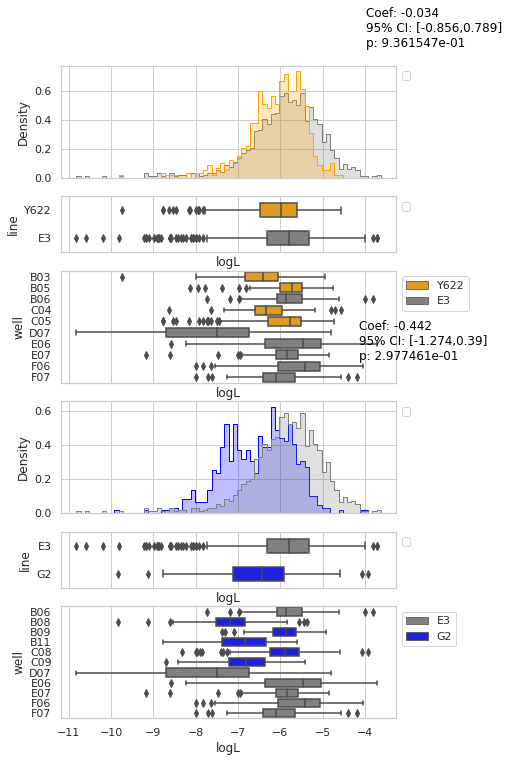

In [16]:
colors = dict(zip(np.unique(resE['line']), ['grey', 'blue', 'orange']))
plot_lines(resE, 'logL', 'vehicle', colors, False, .1, grp='well')


In [9]:
   
def plot_treatments(df_temp, x, colors, lognormal, binwidth,lab_height, line, grp='well', size=(20,7)):
    sns.set(rc={'figure.figsize':size})
    sns.set_style("whitegrid")
    #df_temp = df[df['line']==line]
    


    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(3,len(np.unique(df_temp['treatment']))-1, sharex=True, gridspec_kw={"height_ratios": (1,.3,.5)})

    for i,t in enumerate(['CDP-choline',  'rosiglitazone']):
        index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
        index2 = ((df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)) &  (df_temp['line']==line)
        # compute pvalue 
        
        text = compute_nested_anova(df_temp[index2], x, 'treatment', grp)
        sns.histplot(data=df_temp[index].sort_values(by='treatment', ascending=True), x=x, ax=ax[0,i], hue='treatment2', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
        
        ax[0,i].text(x=np.mean(df_temp[index][x]), y=lab_height, s=text, fontsize=12, color='black')
        
        #ax[0,i].legend(loc='lower left', bbox_to_anchor=(0, 1))
        sns.boxplot(data=df_temp[index], x=x, y='treatment2',orient="h", ax=ax[1,i], width=.8, dodge=True, palette = colors)#, order =(order))#, palette = colors)
        sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[2,i], width=1, dodge=False, hue = 'treatment2', palette = colors)#, order =(order))#, palette = colors)
        #ax[0,i].get_legend().remove()
        ax[2,i].get_legend().remove()
        ax[1,i].axes.get_yaxis().set_visible(False)



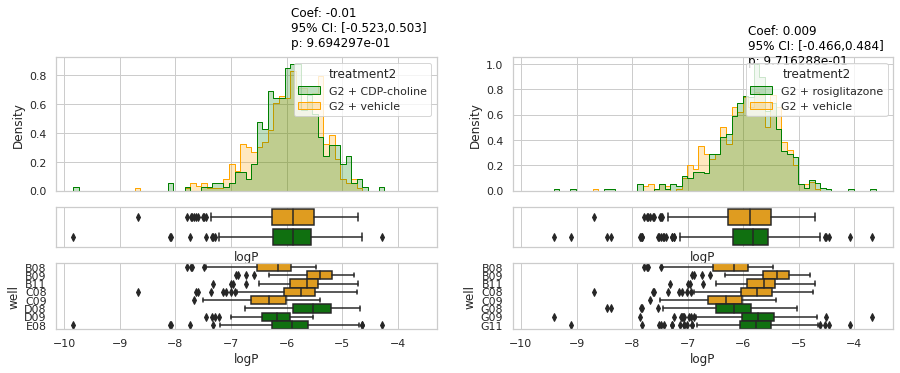

In [19]:
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='G2')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'logP', colors, False, 0.1, 1, line='G2', grp='well', size=(15,5))


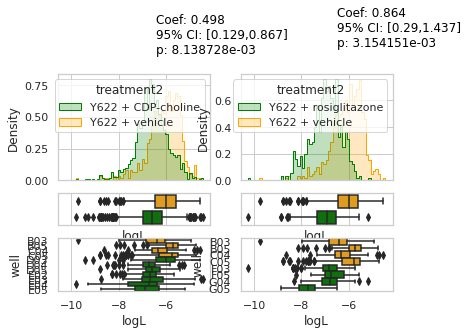

In [10]:
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='Y622')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'logL', colors, False, 0.1, 1, line='Y622', grp='well', size=(15,5))


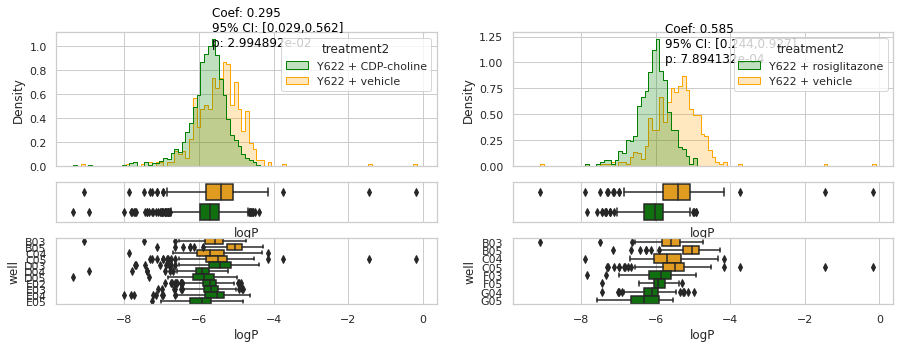

In [11]:
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='Y622')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'logP', colors, False, 0.1, 1, line='Y622', grp='well', size=(15,5))


#### droplet analysis

In [5]:
import cv2 as cv
from skimage import measure, io, color
from cellpose.utils import stitch3D

In [24]:
import time
import numba as nb

In [105]:
def prep_intputs(image_id, zi_per_job, Nzi_per_job, all_masks, files, parent, channels):
    start = image_id*zi_per_job
    end = start + Nzi_per_job[image_id][0]
    masks_sele = all_masks[start:end]

    cells = np.unique(masks_sele)

    img = AICSImage(parent + files[image_id])
    out = load_3D(img, channels)

    return out, cells, masks_sele


#@nb.njit(parallel=True)
def get_percentile(files, channels, target_channel):
    x = []
    for i in nb.prange(len(files)):
        img = AICSImage(parent + files[i])
        out = load_3D(img, channels)
        x.append(out[:,:,:,target_channel].ravel())
    return x

def stack_data(x, percentile):
    f = np.hstack(x)
    P = np.percentile(f, percentile)
    return P

def get_particle_labels(out, target_channel, P, kernel, labels):
    for i in (range(out.shape[0])):
        temp = out[i,:,:,target_channel]
        thresh, ret = cv.threshold(temp, thresh=P, maxval=1, type=cv.THRESH_BINARY)
        opening = cv.morphologyEx(ret, cv.MORPH_OPEN, kernel)
        label_image = measure.label(opening, connectivity=1) 
        labels.append(label_image)

    o = stitch3D(labels, stitch_threshold=.9)
    o = np.concatenate([x[None,:] for x in o], axis=0)
    
    return o

import numba as nb
#@nb.njit()
def copy_array(o, masks_sele, cell):
    temp = o.copy()
    temp[masks_sele!=cell]=0
    return temp

def measure_particles_per_cell(o, masks_sele, out):
    dfs = []
    for cell in cells:
        temp = copy_array(o, masks_sele, cell)
        f = pd.DataFrame(measure.regionprops_table(temp, out[:,:,:,2], properties=('area', 'intensity_mean')))
        
        f['cell_id'] = cell
        
        if f.shape[0]==0:
            d = {'area': 0, 'intensity_mean': 0, 'cell_id': cell}
            f = pd.concat((f, pd.DataFrame.from_dict(data=d, orient="index").T))
        dfs.append(f)
        
    return dfs

def format_results(dfs, all_out):
    
    dfs2 = pd.concat(dfs)
    dfs2['line'] = lines[image_id]
    dfs2['treat'] = treat[image_id]
    dfs2['image_id'] = image_id
    dfs2['file'] = files[image_id]

    all_out.append(dfs2)
    
def process_image(all_out):
    out, cells, masks_sele = prep_intputs(image_id, zi_per_job, Nzi_per_job, all_masks, files, parent, channels)
    o = get_particle_labels(out, 2, 22, np.ones((2,2),np.uint8), [])
    dfs = measure_particles_per_cell(o, masks_sele, out)
    format_results(dfs, all_out)
    
  
### run process_image in parallel
### add visual / QC outputs and coordinates
### last step
df = pd.DataFrame(np.vstack(all_out))
df.columns = ['area', 'intensity_mean', 'cell_id', 'line', 'treat', 'image_id', 'file']


In [53]:
x = get_percentile(files, channels, 99, 2)

In [104]:
all_out = []
for image_id in range(2):
    out, cells, masks_sele = prep_intputs(image_id, zi_per_job, Nzi_per_job, all_masks, files, parent, channels)
    o = get_particle_labels(out, 2, 22, np.ones((2,2),np.uint8), [])
    dfs = measure_particles_per_cell(o, masks_sele, out)
    format_results(dfs, all_out)

/state/partition1/slurm_tmp/25362140.0.0/ipykernel_957743/2865480791.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  temp[masks_sele!=cell]=0


In [60]:
out, cells, masks_sele = prep_intputs(image_id, zi_per_job, Nzi_per_job, all_masks, files, parent, channels)

In [70]:
o = get_particle_labels(out, 2, 22, np.ones((2,2),np.uint8), [])

In [106]:
import timeit
import functools

f = functools.partial(prep_intputs, image_id, zi_per_job, Nzi_per_job, all_masks, files, parent, channels)
g = functools.partial(get_percentile, files, channels, 2)
h = functools.partial(stack_data, x, 99)
d = functools.partial(get_particle_labels,out, 2, 22, np.ones((2,2),np.uint8), [])

i = functools.partial(process_image, all_out)

In [95]:
gg = functools.partial(measure_particles_per_cell,o, masks_sele, out)

In [107]:
#execution_time = timeit.timeit(f, number=1)
#execution_time = timeit.timeit(g, number=1)
#execution_time = timeit.timeit(h, number=1)
#execution_time = timeit.timeit(d, number=1)
execution_time = timeit.timeit(i, number=1)

execution_time

4.453360476065427

In [109]:
(5*90)/60

7.5

In [97]:
#@nb.njit()


In [100]:
dfs = measure_particles_per_cell(o, masks_sele, out)

In [102]:
all_out = []
format_results(dfs, all_out)

In [103]:
all_out

[    area  intensity_mean  cell_id  line    treat  image_id       file
 0    4.0          36.000        0  Y622  vehicle         0  B03-1.czi
 1    4.0          25.500        0  Y622  vehicle         0  B03-1.czi
 2    4.0          13.500        0  Y622  vehicle         0  B03-1.czi
 3    8.0          17.375        0  Y622  vehicle         0  B03-1.czi
 4    4.0          62.750        0  Y622  vehicle         0  B03-1.czi
 ..   ...             ...      ...   ...      ...       ...        ...
 2   12.0          33.250       40  Y622  vehicle         0  B03-1.czi
 0    0.0           0.000       41  Y622  vehicle         0  B03-1.czi
 0    4.0          13.000       42  Y622  vehicle         0  B03-1.czi
 0    0.0           0.000       43  Y622  vehicle         0  B03-1.czi
 0    0.0           0.000       44  Y622  vehicle         0  B03-1.czi
 
 [573 rows x 7 columns]]

In [ ]:

df = pd.DataFrame(np.vstack(all_out))
df.columns = ['area', 'intensity_mean', 'cell_id', 'line', 'treat', 'image_id', 'file']


In [62]:
 dfs = []
    for cell in cells:
        temp = copy_array(o, masks_sele, cell)
        #temp = o.copy()
        #temp[masks_sele!=cell]=0
        f = pd.DataFrame(measure.regionprops_table(temp, out[:,:,:,2], properties=('area', 'intensity_mean')))
        f['cell_id'] = cell
        
        if f.shape[0]==0:
            d = {'area': 0, 'intensity_mean': 0, 'cell_id': cell}
            f = pd.concat((f, pd.DataFrame.from_dict(data=d, orient="index").T))
            #f = #f.append({'area': 0, 'intensity_mean': 0, 'cell_id': cell}, ignore_index=True)
        dfs.append(f)


    dfs2 = pd.concat(dfs)
    dfs2['line'] = lines[image_id]
    dfs2['treat'] = treat[image_id]
    dfs2['image_id'] = image_id
    dfs2['file'] = files[image_id]

    all_out.append(dfs2)
    
df = pd.DataFrame(np.vstack(all_out))
df.columns = ['area', 'intensity_mean', 'cell_id', 'line', 'treat', 'image_id', 'file']


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [135]:
# 1: P = 18
# 0: P = 22

In [ ]:
#### Speed up below
#### add visual QC so that can see the LDs called
#### add coordinate so that can compare co-localization of LDs and PLIN

In [250]:
P = 22

channels = [3, 2, 0]

all_out = []
data_out = []
im_out = []
im_out2 = []
im_out3 = []

from timeit import default_timer as timer

for image_id in tqdm(range(len(files))):
    
    start = image_id*zi_per_job
    end = start + Nzi_per_job[image_id][0]
    masks_sele = all_masks[start:end]

    cells = np.unique(mask_sele)
    
    img = AICSImage(parent + files[image_id])
    out = load_3D(img, channels)
    labels = []
        
    for i in (range(out.shape[0])):
        temp = out[i,:,:,2]
        thresh, ret = cv.threshold(temp, thresh=P, maxval=1, type=cv.THRESH_BINARY)
        kernel = np.ones((2,2),np.uint16)
        opening = cv.morphologyEx(ret, cv.MORPH_OPEN, kernel)
        label_image = measure.label(opening, connectivity=1) 
        labels.append(label_image)
        
    o = stitch3D(labels, stitch_threshold=.9)
    o = np.concatenate([x[None,:] for x in o], axis=0)
    
    dfs = []
    for cell in cells:
        temp = copy_array(o, masks_sele, cell)
        #temp = o.copy()
        #temp[masks_sele!=cell]=0
        f = pd.DataFrame(measure.regionprops_table(temp, out[:,:,:,2], properties=('area', 'intensity_mean')))
        f['cell_id'] = cell
        
        if f.shape[0]==0:
            d = {'area': 0, 'intensity_mean': 0, 'cell_id': cell}
            f = pd.concat((f, pd.DataFrame.from_dict(data=d, orient="index").T))
            #f = #f.append({'area': 0, 'intensity_mean': 0, 'cell_id': cell}, ignore_index=True)
        dfs.append(f)


    dfs2 = pd.concat(dfs)
    dfs2['line'] = lines[image_id]
    dfs2['treat'] = treat[image_id]
    dfs2['image_id'] = image_id
    dfs2['file'] = files[image_id]

    all_out.append(dfs2)
    
df = pd.DataFrame(np.vstack(all_out))
df.columns = ['area', 'intensity_mean', 'cell_id', 'line', 'treat', 'image_id', 'file']


 27%|██▋       | 20/75 [06:40<18:20, 20.01s/it]


KeyboardInterrupt: 

In [226]:
from datetime import timedelta


In [227]:
print(timedelta(seconds=end-start))


24 days, 8:26:42.130713


In [212]:
import numba as nb
nb.njit()
def copy_array(o, masks_sele, cell):
    temp = o.copy()
    temp[masks_sele!=cell]=0
    return temp

In [210]:
   for cell in cells:
        temp = o.copy()
        temp[masks_sele!=cell]=0
        #f = pd.DataFrame(measure.regionprops_table(temp, out[:,:,:,2], properties=('area', 'intensity_mean')))
        #f['cell_id'] = cell
        
        #if f.shape[0]==0:
        #    f = f.append({'area': 0, 'intensity_mean': 0, 'cell_id': cell}, ignore_index=True)
        #dfs.append(f)

In [204]:
df['well'] = [x.split('-')[0] for x in df['file']]

In [205]:
df

,area,intensity_mean,cell_id,line,treat,image_id,file,well
0,4.0,17.5,0,Y622,vehicle,0,B03-1.czi,B03
1,4.0,18.75,0,Y622,vehicle,0,B03-1.czi,B03
2,4.0,25.5,0,Y622,vehicle,0,B03-1.czi,B03
3,4.0,20.0,0,Y622,vehicle,0,B03-1.czi,B03
4,11.0,20.363636,0,Y622,vehicle,0,B03-1.czi,B03
...,...,...,...,...,...,...,...,...
1305,0.0,0.0,88,Y622,vehicle,1,B03-2.czi,B03
1306,0.0,0.0,89,Y622,vehicle,1,B03-2.czi,B03
1307,0.0,0.0,90,Y622,vehicle,1,B03-2.czi,B03
1308,0.0,0.0,91,Y622,vehicle,1,B03-2.czi,B03


In [194]:
f = f.append({'area': 0, 'intensity_mean': 0, 'cell_id': cell}, ignore_index=True)

IndexError: single positional indexer is out-of-bounds

In [179]:
f['label'] = 2

In [187]:
f.label = 2

In [188]:
f

,label,area,intensity_mean,cell_id


In [184]:
f

,label,area,intensity_mean,cell_id


In [173]:
df

,label,area,intensity_mean,cell_id,line,treat,image_id,file
0,1,4.0,17.5,0,Y622,vehicle,0,B03-1.czi
1,2,4.0,18.75,0,Y622,vehicle,0,B03-1.czi
2,3,4.0,25.5,0,Y622,vehicle,0,B03-1.czi
3,4,4.0,20.0,0,Y622,vehicle,0,B03-1.czi
4,5,11.0,20.363636,0,Y622,vehicle,0,B03-1.czi
...,...,...,...,...,...,...,...,...
1177,334,8.0,19.75,24,Y622,vehicle,1,B03-2.czi
1178,335,6.0,15.0,24,Y622,vehicle,1,B03-2.czi
1179,336,4.0,16.75,24,Y622,vehicle,1,B03-2.czi
1180,443,4.0,29.5,27,Y622,vehicle,1,B03-2.czi


In [136]:
P = 

channels = [3, 2, 1]

all_out = []
data_out = []
im_out = []
im_out2 = []
im_out3 = []

for image_id in tqdm(range(2)):
    
    start = image_id*zi_per_job
    end = start + Nzi_per_job[image_id][0]
    masks_sele = all_masks[start:end]

    img = AICSImage(parent + files[image_id])
    out = load_3D(img, channels)
    labels = []
        
    for i in (range(out.shape[0])):
        temp = out[i,:,:,2]
        thresh, ret = cv.threshold(temp, thresh=P, maxval=1, type=cv.THRESH_BINARY)
        kernel = np.ones((2,2),np.uint16)
        opening = cv.morphologyEx(ret, cv.MORPH_OPEN, kernel)
        label_image = measure.label(opening, connectivity=1) 
        label_image[masks_sele[i]==0] = 0
        labels.append(label_image)#[None,:])
        
    o = stitch3D(labels, stitch_threshold=.9)
    o = np.concatenate([x[None,:] for x in o], axis=0)
    f = pd.DataFrame(measure.regionprops_table(o, out[:,:,:,2], properties=('label', 'area', 'intensity_mean')))
    

    out = int_to_float(out)
    x = np.mean(out[:,:,:,2], axis=0)[:,:,None]
    x = x/np.percentile(x, 99.99)
    y = np.mean(o, axis=0)[:,:,None]
    y[y>0] = 1

    z = np.mean(masks_sele, axis=0)[:,:,None]
    #z = z/np.percentile(z, 99)    
    im_out.append(np.concatenate((y,x,z),axis=2))
   
    z = np.zeros_like(y)
    im_out2.append(np.concatenate((y,x,z),axis=2))

    y = np.zeros_like(x)
    im_out3.append(np.concatenate((y,x,z),axis=2))


    f['line'] = lines[image_id]
    f['treat'] = treat[image_id]
    f['image_id'] = image_id
    f['file'] = files[image_id]

    all_out.append(f)
    
df = pd.DataFrame(np.vstack(all_out))
df.columns = ['label', 'area', 'intensity_mean', 'line', 'treat', 'image_id', 'file']


  0%|          | 0/2 [00:00<?, ?it/s]/home/gridsan/djuna/.local/lib/python3.8/site-packages/cellpose/metrics.py:208: RuntimeWarning: invalid value encountered in divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
 50%|█████     | 1/2 [00:01<00:01,  1.23s/it]/home/gridsan/djuna/.local/lib/python3.8/site-packages/cellpose/metrics.py:208: RuntimeWarning: invalid value encountered in divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


In [140]:
df

,label,area,intensity_mean,line,treat,image_id,file
0,13,6.0,20.0,Y622,vehicle,0,B03-1.czi
1,29,4.0,7.0,Y622,vehicle,0,B03-1.czi
2,32,4.0,18.25,Y622,vehicle,0,B03-1.czi
3,35,4.0,21.75,Y622,vehicle,0,B03-1.czi
4,38,4.0,9.25,Y622,vehicle,0,B03-1.czi
...,...,...,...,...,...,...,...
105,201,18.0,29.888889,Y622,vehicle,1,B03-2.czi
106,202,9.0,43.111111,Y622,vehicle,1,B03-2.czi
107,209,4.0,18.25,Y622,vehicle,1,B03-2.czi
108,228,19.0,38.052632,Y622,vehicle,1,B03-2.czi


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


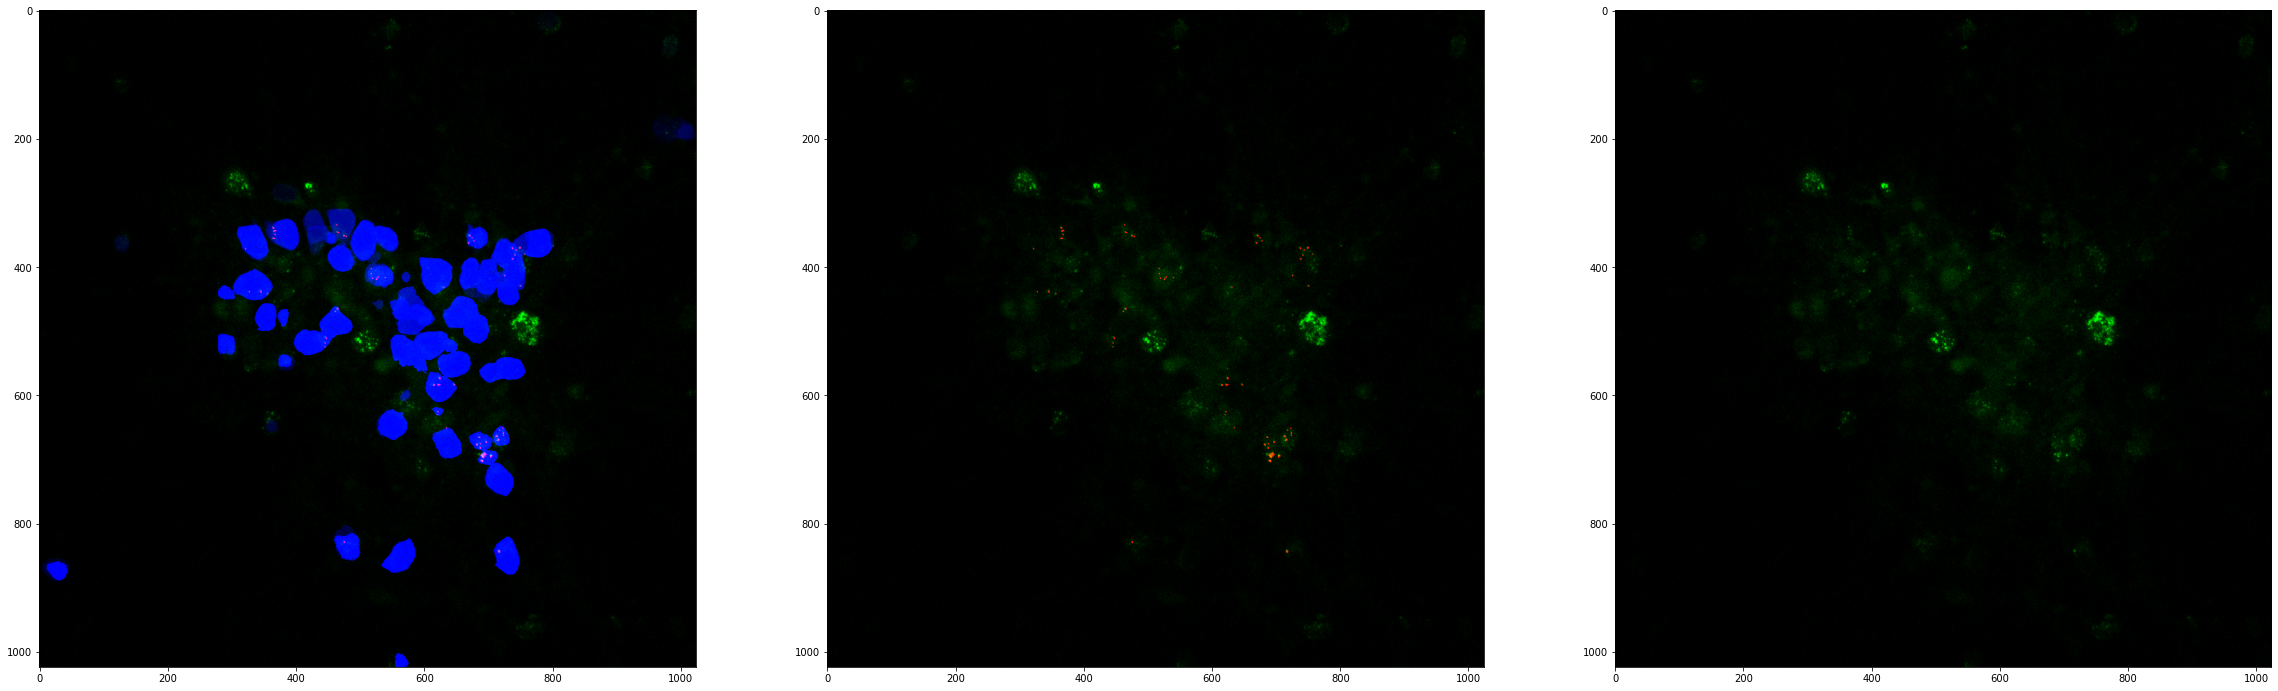

In [138]:
fig, axes = plt.subplots(1, 3, figsize=(40, 20))

for ax, image in zip(axes, [im_out[0], im_out2[0], im_out3[0]]):
    ax.imshow(image, cmap='gray')
    #ax.set_xlim(200,400)  # Set x limits
    #ax.set_ylim(300,500)  # Set y limits

# axes[0].imshow(im_out[0])
# axes[1].imshow(im_out2[0])
# axes[2].imshow(im_out3[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


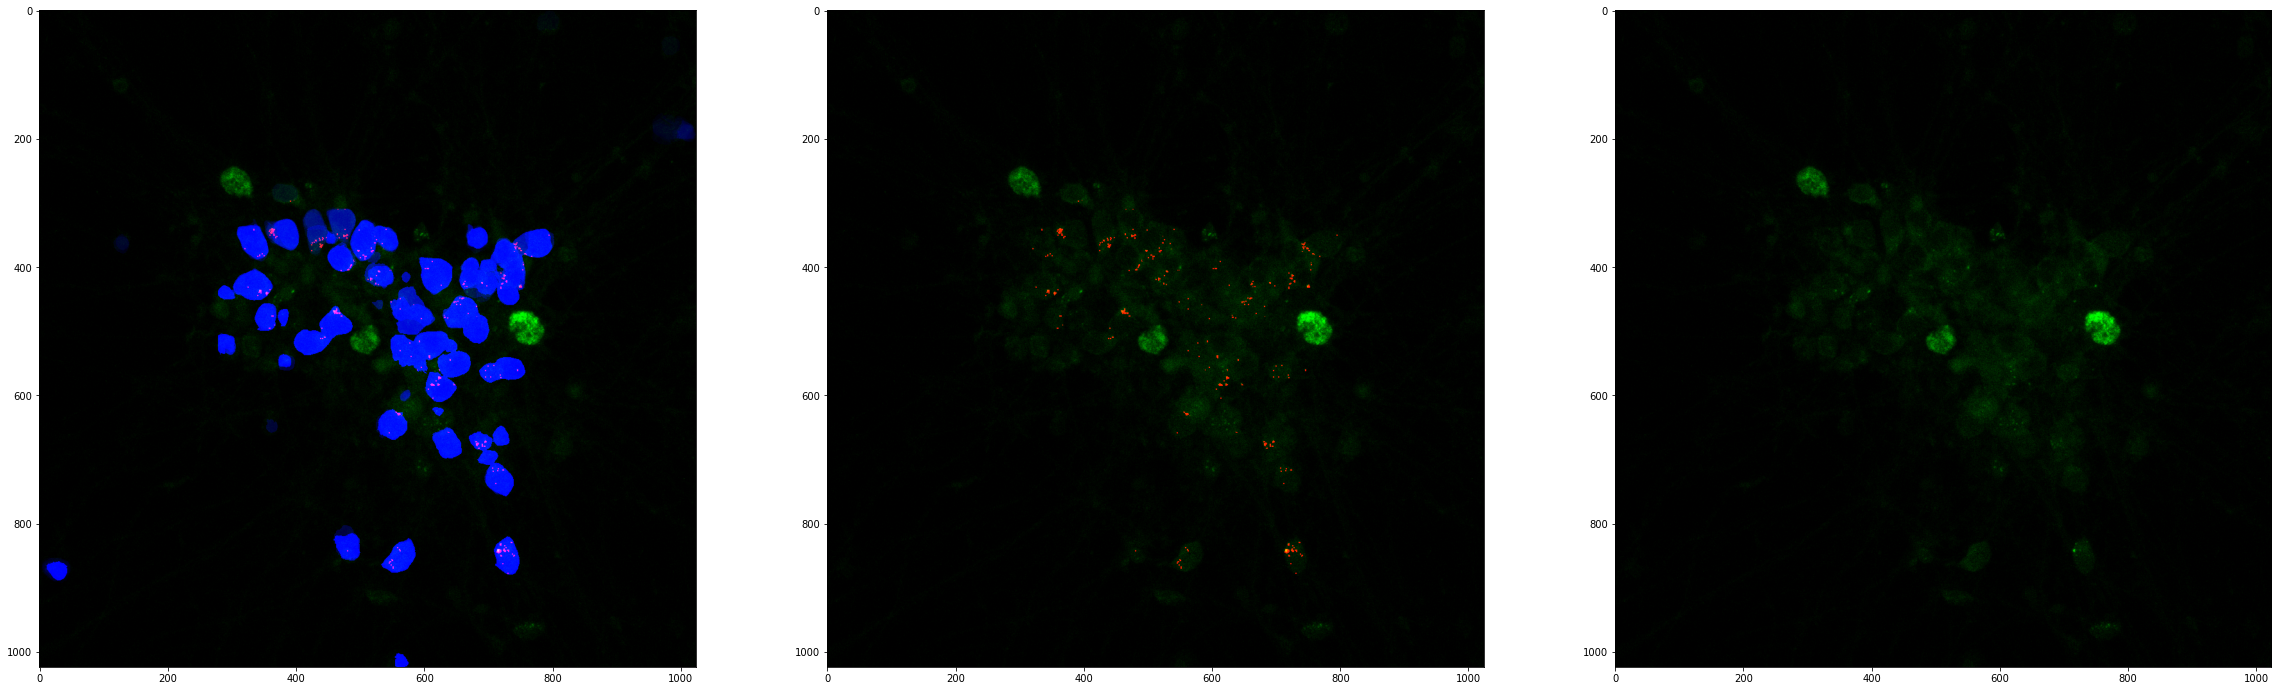

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(40, 20))

for ax, image in zip(axes, [im_out[0], im_out2[0], im_out3[0]]):
    ax.imshow(image, cmap='gray')
    #ax.set_xlim(200,400)  # Set x limits
    #ax.set_ylim(300,500)  # Set y limits

# axes[0].imshow(im_out[0])
# axes[1].imshow(im_out2[0])
# axes[2].imshow(im_out3[0])

memmap([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [47]:
o = stitch3D(labels, stitch_threshold=.25)

In [48]:
o

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [ ]:
df.to_csv('temp_lspot_new.csv')

# show rep images

In [7]:
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels, impose_segmentation, float_to_int, hide_masks
from confocalQuant.image import add_scale_bar, add_inset, plot_axis,  get_mean_projections,  get_rep_im
from confocalQuant.data_handling import get_id_data,compute_avs
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage

In [8]:
# get rep images
treatments = np.unique(resE['treatment'])
dict_treat = dict(zip(resE['file'], resE['treatment']))
dict_line = dict(zip(resE['file'], resE['line']))

mean_per_filename, mean_per_condition = compute_avs(resE, 'file', 'treatment', 'line', 'channel_PLIN')

In [9]:
#vehicle = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
e3_rep = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
y622_rep = get_rep_im('CDP-choline', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
g2_rep = get_rep_im('rosiglitazone', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

rep = [e3_rep, y622_rep,g2_rep]

In [10]:
# define column names
collabs = ['DAPI + Mask',  'DAPI + NRF2']
rowlabs = ['E3', 'Y622', 'G2']

In [20]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mat_sele, mask_sele = get_id_data(i, zi_per_job, Nzi_per_job, all_mat, all_masks)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([0,1,3], mat_sele)

nums = [95, 95, 99.9] 
upper_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))
lower_dict = {0: 0, 1: 0, 2: 0}
gamma_dict = {0: 1, 1: 1, 2: 1}
background_dict = {0: 0, 1: 75, 2: 75}
percentile=False

In [ ]:
# Ch1-NRF2 > Ch2-CTP1B > Ch3-NeuN/GFP > Ch4-DAPI

In [173]:
x1=[0,300,200]
x2=[200,500,400]
y1=[500,400,550]
y2=[700,600,750]

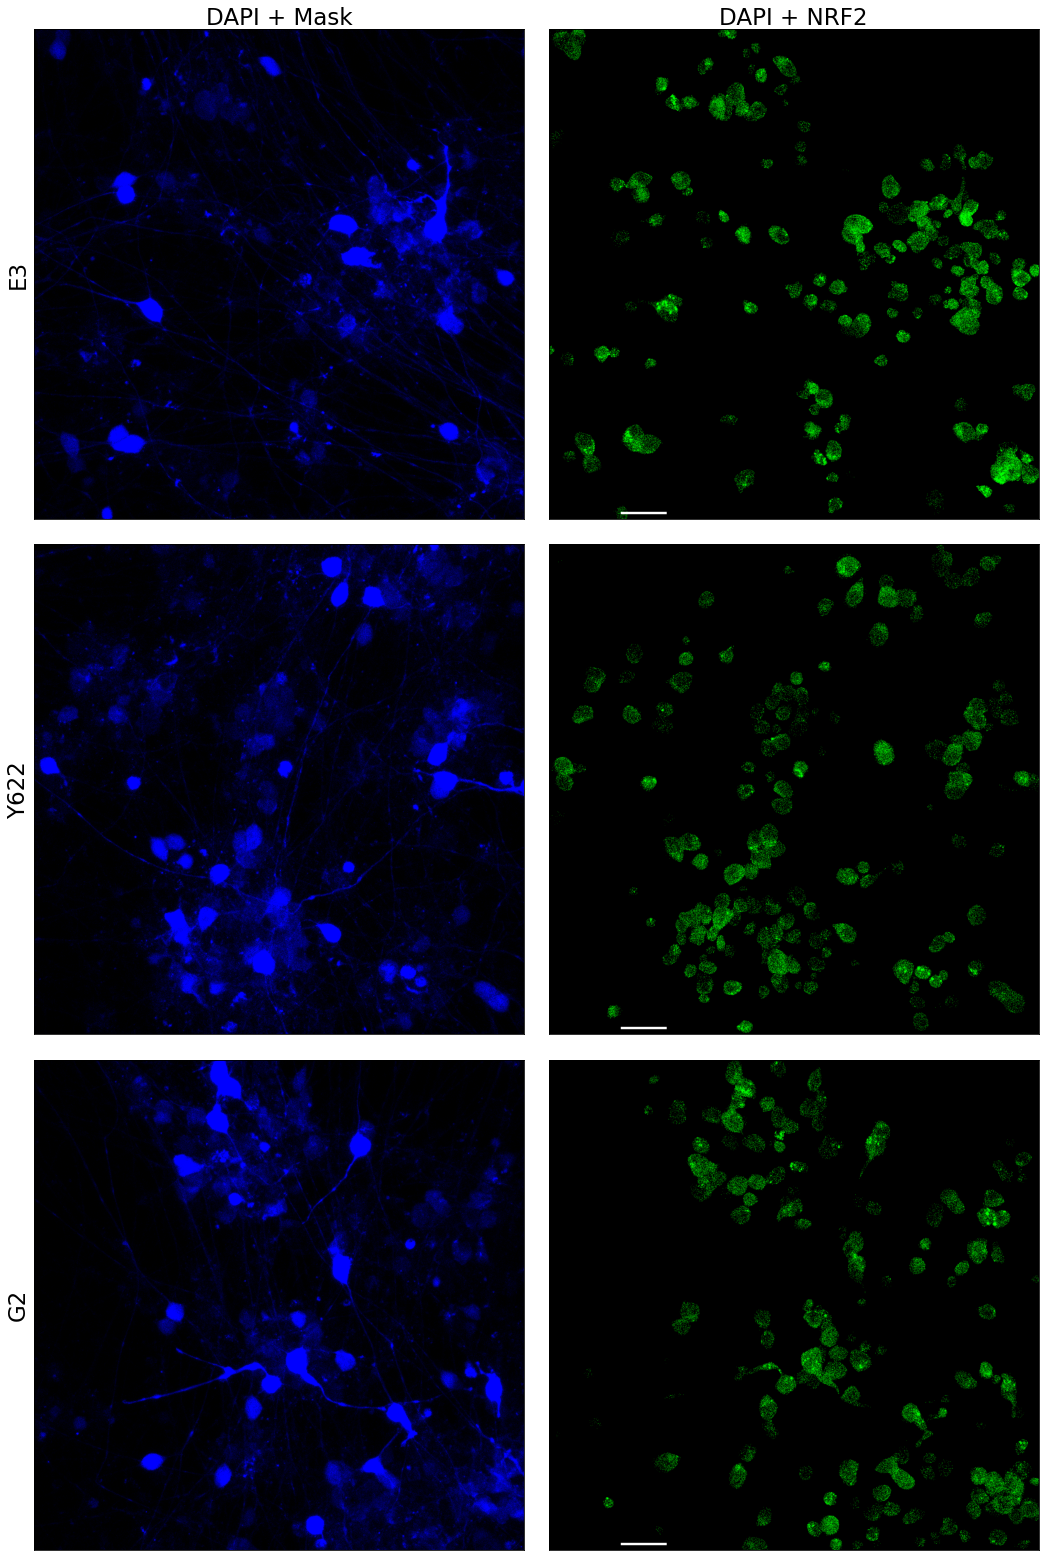

In [21]:
# show images
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(18, 28))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mat_sele, mask_sele = get_id_data(ID, zi_per_job, Nzi_per_job, all_mat, all_masks)
    mat_sele = extract_channels([1,2], mat_sele)

    # make plots
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[0,2,1], mask_channel = [2], maskit=True, percentile=percentile, mean=False)
    d = impose_segmentation(mask_sele, mat_sele, val=1)
    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[1], order=[0,2,1], mask_channel = [0], maskit=False, percentile=percentile)

    # get image
    imgA = AICSImage(parent + files[ID])

    plot_axis(axes, plt2, i,0, 0, imgA, collabs, rowlabs)
    plot_axis(axes, plt1, i,1, 30, imgA, collabs, rowlabs)
    
   # plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 0, imgA, collabs, rowlabs)
    #plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 30, imgA, collabs, rowlabs)
    
